## Install and Setup a Spark session.

In [49]:
!pip install pyspark

In [50]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Weather Analysis").getOrCreate()

## <b>1 <span style='color:#0386f7de'>|</span> Reading and Understanding the Datasets</b>

In [51]:
df_weather = spark.read.csv('LCD_sample.csv', header=True, inferSchema=True)
df_weather.show(5)


+----------+--------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-------------------

## <b>2 <span style='color:#0386f7de'>|</span> Data Cleaning</b>

In [52]:
df_weather.count()

772

**Indeed non-null and non-NaN values**

In [53]:
from pyspark.sql.functions import isnan, when, count, col

# Count non-NaN values for each field
df_weather.select([count(when(~isnan(c) & ~col(c).isNull(), c)).alias(c) for c in ["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"]]).show()


+-------------------------+----------------------+
|HourlyDryBulbTemperatureF|HourlyRelativeHumidity|
+-------------------------+----------------------+
|                      742|                   742|
+-------------------------+----------------------+



**Check for Empty Strings**

In [54]:
# Replace empty strings with nulls in specified columns and display the DataFrame
df = df_weather \
    .withColumn("HourlyDryBulbTemperatureF", when(col("HourlyDryBulbTemperatureF") == "", None).otherwise(col("HourlyDryBulbTemperatureF"))) \
    .withColumn("HourlyRelativeHumidity", when(col("HourlyRelativeHumidity") == "", None).otherwise(col("HourlyRelativeHumidity")))

# Show the DataFrame in an organized manner
df.show(truncate=False, n=5)



+----------+-----------------------------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+----------------

**Fill Missing Values**

In [55]:
df = df_weather.na.fill({"HourlyDryBulbTemperatureF": 0, "HourlyRelativeHumidity": 0})


**Create our pipeline**

In [56]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"],
    outputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"]
).setStrategy("median")


In [57]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"],
    outputCol="features"
)

# Define StandardScaler to scale the numerical features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

In [58]:
# Define the pipeline which consists of stages
pipeline = Pipeline(stages=[imputer, assembler, scaler])

# Now you can fit and transform your pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

In [59]:
# Show the results of the transformation
df_transformed.show()

+----------+--------------------+---------+--------+---------+--------------+----------+--------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-----------------

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import IntegerType

# # Define mapping functions for weather patterns
# weather_type_mapping = {
#     'SN': 1,  # Snow
#     'TS': 2,  # Thunderstorm
#     'RA': 3,  # Rain
#     'DZ': 4,  # Drizzle
#     'FG': 5,  # Fog
#     '-SN': 6,  # Light Snow
#     '+SN': 7,  # Heavy Snow
#     'HZ': 8,  # Haze
#     'FU': 9,  # Smoke
#     # Add more patterns as needed...
# }

# # Define UDF to convert weather patterns to numeric values
# def convert_weather_pattern(weather_str):
#     if weather_str:
#         main_type = weather_str.split(':')[0]  # Extract primary weather condition
#         return weather_type_mapping.get(main_type, -1)  # Return mapped value, or -1 if not found
#     return -1

# # Register the UDF
# convert_weather_udf = udf(convert_weather_pattern, IntegerType())

# # Apply UDF to convert 'HourlyPresentWeatherType' to numeric values
# df_weather = df_weather.withColumn('numeric_HourlyPresentWeatherType', convert_weather_udf(col('HourlyPresentWeatherType')))

# # Example UDF for converting 'HourlySkyConditions' (mapping already defined earlier)
# cloud_coverage_mapping = {
#     'CLR': 0,
#     'FEW': 1,
#     'SCT': 4,
#     'BKN': 7,
#     'OVC': 8
# }

# def convert_cloud_coverage(cloud_str):
#     if cloud_str:
#         main_type = cloud_str.split(':')[0]
#         return cloud_coverage_mapping.get(main_type, -1)
#     return -1

# # Register and apply the UDF for 'HourlySkyConditions'
# convert_cloud_udf = udf(convert_cloud_coverage, IntegerType())
# df_weather = df_weather.withColumn('numeric_HourlySkyConditions', convert_cloud_udf(col('HourlySkyConditions')))

# # Display the updated dataset
# df_weather.select('STATION', 'STATION_NAME','HourlyPresentWeatherType', 'numeric_HourlyPresentWeatherType', 'HourlySkyConditions', 'numeric_HourlySkyConditions').show(truncate=False)

# # Verify the schema
# df_weather.printSchema()


+----------+-----------------------------------------+------------------------+--------------------------------+------------------------------+---------------------------+
|STATION   |STATION_NAME                             |HourlyPresentWeatherType|numeric_HourlyPresentWeatherType|HourlySkyConditions           |numeric_HourlySkyConditions|
+----------+-----------------------------------------+------------------------+--------------------------------+------------------------------+---------------------------+
|WBAN:94846|CHICAGO OHARE INTERNATIONAL AIRPORT IL US|NULL                    |-1                              |SCT:04 70 OVC:08 90           |4                          |
|WBAN:94846|CHICAGO OHARE INTERNATIONAL AIRPORT IL US|NULL                    |-1                              |OVC:08 50                     |8                          |
|WBAN:94846|CHICAGO OHARE INTERNATIONAL AIRPORT IL US|-SN:03 |SN:71 |         |6                               |OVC:08 29                   

In [61]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Define mapping functions for weather patterns
weather_type_mapping = {
    'SN': 1,  # Snow
    'TS': 2,  # Thunderstorm
    'RA': 3,  # Rain
    'DZ': 4,  # Drizzle
    'FG': 5,  # Fog
    '-SN': 6,  # Light Snow
    '+SN': 7,  # Heavy Snow
    'HZ': 8,  # Haze
    'FU': 9,  # Smoke
    # Add more patterns as needed...
}

# Define UDF to convert weather patterns to numeric values
def convert_weather_pattern(weather_str):
    if weather_str:
        main_type = weather_str.split(':')[0]  # Extract primary weather condition
        return weather_type_mapping.get(main_type, -1)  # Return mapped value, or -1 if not found
    return -1

# Register the UDF
convert_weather_udf = udf(convert_weather_pattern, IntegerType())

# Apply UDF to convert 'HourlyPresentWeatherType' to numeric values
df_weather = df_weather.withColumn('numeric_HourlyPresentWeatherType', convert_weather_udf(col('HourlyPresentWeatherType')))

# Example UDF for converting 'HourlySkyConditions' (mapping already defined earlier)
cloud_coverage_mapping = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 4,
    'BKN': 7,
    'OVC': 8
}

def convert_cloud_coverage(cloud_str):
    if cloud_str:
        main_type = cloud_str.split(':')[0]
        return cloud_coverage_mapping.get(main_type, -1)
    return -1

# Register and apply the UDF for 'HourlySkyConditions'
convert_cloud_udf = udf(convert_cloud_coverage, IntegerType())
df_weather = df_weather.withColumn('numeric_HourlySkyConditions', convert_cloud_udf(col('HourlySkyConditions')))

# Display the updated dataset
# log_df =  df_weather.select('STATION', 'STATION_NAME','numeric_HourlyPresentWeatherType', 'numeric_HourlySkyConditions', 'HourlyVisibility',  'HourlyDryBulbTemperatureF', 'HourlyWetBulbTemperatureF', 'HourlyDewPointTemperatureF','HourlyRelativeHumidity', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyStationPressure',  'HourlySeaLevelPressure', 'HourlyPrecipitation', 'HourlyAltimeterSetting' ).show(truncate=False)

selected_columns = [
    'STATION', 'STATION_NAME', 'numeric_HourlyPresentWeatherType', 'numeric_HourlySkyConditions',
    'HourlyVisibility', 'HourlyDryBulbTemperatureF', 'HourlyWetBulbTemperatureF',
    'HourlyDewPointTemperatureF', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
    'HourlyWindDirection', 'HourlyStationPressure', 'HourlySeaLevelPressure',
    'HourlyPrecipitation', 'HourlyAltimeterSetting'
]

# Selecting and displaying the specified columns
result_df = df_weather.select(*selected_columns)


In [62]:
result_df.show(5)

+----------+--------------------+--------------------------------+---------------------------+----------------+-------------------------+-------------------------+--------------------------+----------------------+---------------+-------------------+---------------------+----------------------+-------------------+----------------------+
|   STATION|        STATION_NAME|numeric_HourlyPresentWeatherType|numeric_HourlySkyConditions|HourlyVisibility|HourlyDryBulbTemperatureF|HourlyWetBulbTemperatureF|HourlyDewPointTemperatureF|HourlyRelativeHumidity|HourlyWindSpeed|HourlyWindDirection|HourlyStationPressure|HourlySeaLevelPressure|HourlyPrecipitation|HourlyAltimeterSetting|
+----------+--------------------+--------------------------------+---------------------------+----------------+-------------------------+-------------------------+--------------------------+----------------------+---------------+-------------------+---------------------+----------------------+-------------------+----------

In [63]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when

# Example features and target columns
features = ['HourlyVisibility', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'numeric_HourlySkyConditions']
target = 'numeric_HourlyPresentWeatherType'

# Handle missing values
result_df = result_df.fillna(0)

# Ensure labels are positive and in the required range
result_df = result_df.withColumn(target, when(col(target) < 0, 0).otherwise(col(target)))

# Check if the 'features' column already exists and drop it if necessary
if 'features' in result_df.columns:
    result_df = result_df.drop('features')

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=features, outputCol='features')
result_df = assembler.transform(result_df)

# Select only the features vector and the target column
final_df = result_df.select('features', col(target).alias('label'))

# Split into training and test sets (75% training, 25% testing)
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=130)

# Initialize and train a Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Initialize evaluator with the correct label column
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print(f"Test set accuracy: {accuracy:.2f}")

Test set accuracy: 0.93


# Performing EDA for visibilty and weather conditions

**Correlations between temperature and other variables such as precipitation, humidity, and air pressure**

In [ ]:
# Convert columns to appropriate data types
df = df.withColumn("HourlyDryBulbTemperatureF", df["HourlyDryBulbTemperatureF"].cast("float"))
df = df.withColumn("HourlyPrecipitation", df["HourlyPrecipitation"].cast("float"))


In [ ]:
# Calculate correlation coefficients using the correct column names
correlation_temperature_precipitation = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyPrecipitation")
correlation_temperature_humidity = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyRelativeHumidity")
correlation_temperature_air_pressure = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyStationPressure")

print("Correlation between temperature and precipitation:", correlation_temperature_precipitation)
print("Correlation between temperature and humidity:", correlation_temperature_humidity)
print("Correlation between temperature and air pressure:", correlation_temperature_air_pressure)


Correlation between temperature and precipitation: 0.003949929727518378
Correlation between temperature and humidity: 0.21632030492151427
Correlation between temperature and air pressure: 0.427414289727293


During the correlation calculations, it was noted that the temperatures and air pressures are closely related with a correlation coefficient of 0.427 hence indicating a moderate positive relationship. However, on the contrary, the correlation coefficient between temperatures and amount of rainfall is 0.004 and indicate that the relationship between these two variables in not significant.

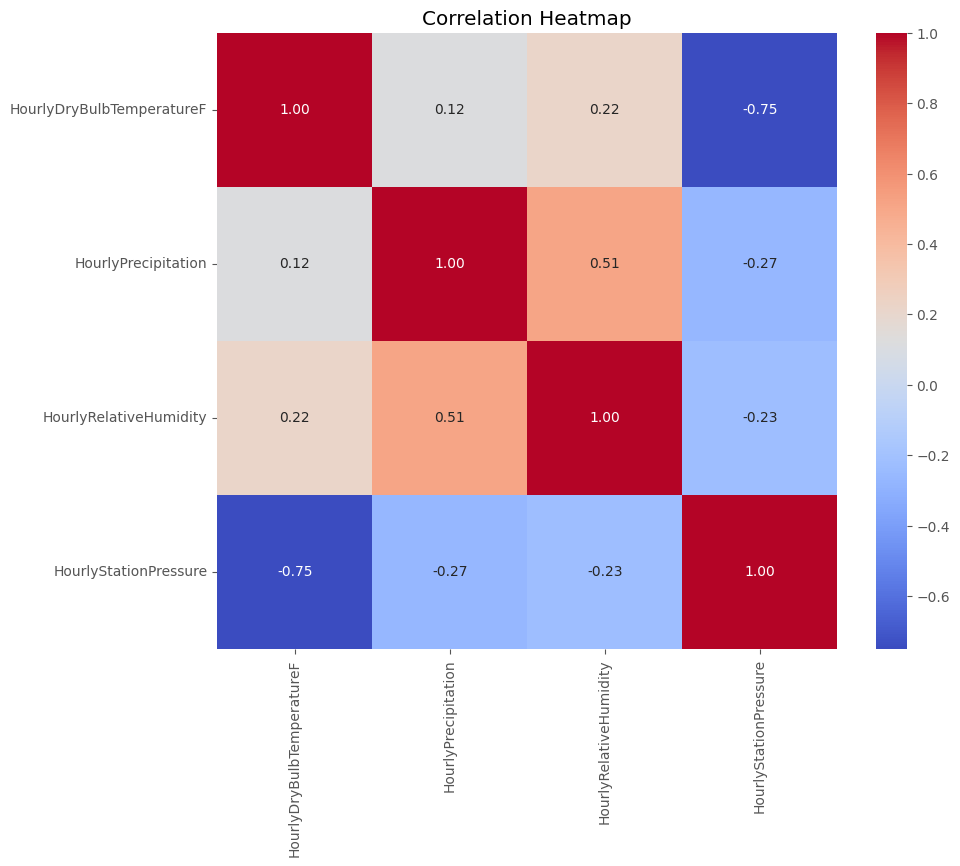

In [ ]:
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = df.select("HourlyDryBulbTemperatureF", "HourlyPrecipitation", "HourlyRelativeHumidity", "HourlyStationPressure").toPandas().corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


* From above showing the correlation heatmap, strong negative correlation is displayed by the hourly dry bulb temperature and hourly station pressure indicators (-0.75) as depicted, indicating that there is indeed an actual relationship which exists between temperature and air pressure.
* However, hourly precipitation exhibits weak correlation coefficient vis-à-vis hourly dry bulb temperature (0.12) implying that the relationship between temperature and precipitation is weak.

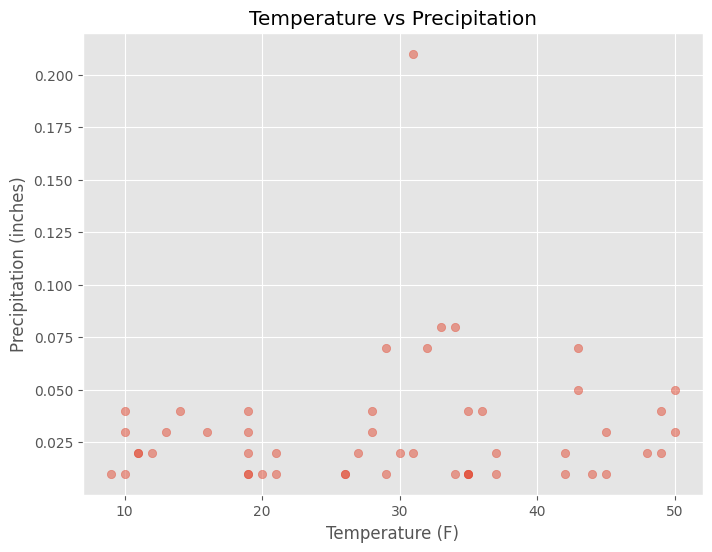

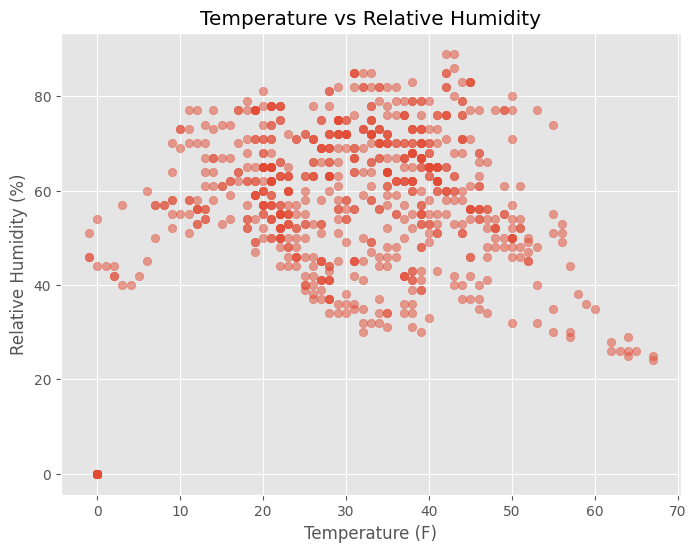

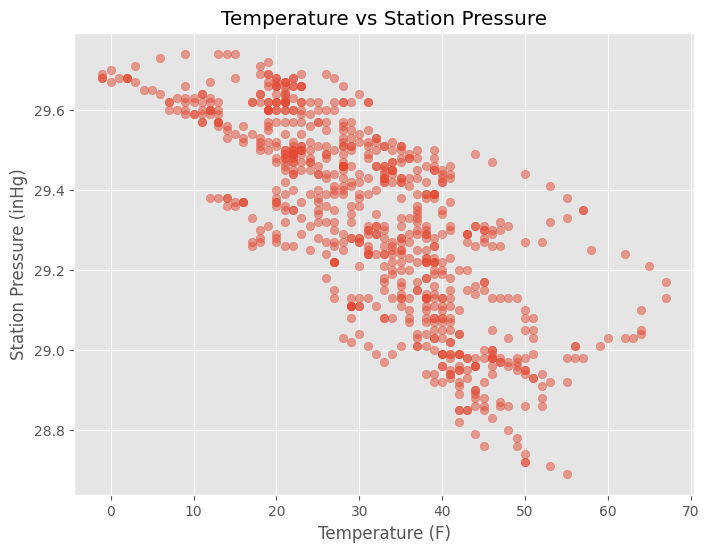

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: Temperature vs Precipitation
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyPrecipitation").collect(), alpha=0.5)
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature (F)')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.show()

# Scatter plot: Temperature vs Relative Humidity
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyRelativeHumidity").collect(), alpha=0.5)
plt.title('Temperature vs Relative Humidity')
plt.xlabel('Temperature (F)')
plt.ylabel('Relative Humidity (%)')
plt.grid(True)
plt.show()

# Scatter plot: Temperature vs Station Pressure
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyStationPressure").collect(), alpha=0.5)
plt.title('Temperature vs Station Pressure')
plt.xlabel('Temperature (F)')
plt.ylabel('Station Pressure (inHg)')
plt.grid(True)
plt.show()


For above graphs, We observe the below points:
 1. The scatter plot "Temperature vs Precipitation“ shows no clear relationship between two variables such that it is apparent that the amount of precipitation is not significantly influenced by temperature.
 2. At higher temperatures especially, relative humidity tends to decline as temperature rises slightly indicated in the scatter plot “Temperature against relative humidity
 3. The scatter plot titled "Temperature vs Station Pressure" provided on the site shows an evident trend which suggest that the more heat there is on this planet’s surface, the lower atmospheric pressure will be felt in every station globally hence confirming how closely related they are.

**Weather Conditions Analysis :**
**Eg: Count of Different Sky Conditions**

In [ ]:
from pyspark.sql.functions import col

# Count occurrences of each type of sky condition
sky_conditions = df.groupBy("HourlySkyConditions").count().orderBy(col("count").desc())

sky_conditions.show()


+--------------------+-----+
| HourlySkyConditions|count|
+--------------------+-----+
|              CLR:00|   72|
|          FEW:02 250|   46|
|                NULL|   30|
|          BKN:07 250|   27|
|          SCT:04 250|   19|
|FEW:02 150 SCT:04...|   10|
|            OVC:08 8|    9|
|           SCT:04 55|    8|
|           FEW:02 50|    8|
|           OVC:08 25|    7|
|           OVC:08 60|    7|
|BKN:07 150 OVC:08...|    7|
|           OVC:08 14|    6|
|           OVC:08 15|    6|
|FEW:02 180 BKN:07...|    5|
|           OVC:08 17|    5|
|          OVC:08 100|    5|
|           OVC:08 16|    5|
|           FEW:02 80|    4|
|           OVC:08 27|    4|
+--------------------+-----+
only showing top 20 rows



**3. Correlation Analysis**

In [ ]:
from pyspark.sql.functions import corr

# Calculate correlation between temperature and relative humidity
temperature_humidity_corr = df.select(corr("HourlyDryBulbTemperatureF", "HourlyRelativeHumidity").alias("Temp_Humidity_Correlation"))

temperature_humidity_corr.show()


+-------------------------+
|Temp_Humidity_Correlation|
+-------------------------+
|      0.21632030492151427|
+-------------------------+



**4. Visualization**

In [ ]:
df.select('HourlyDryBulbTemperatureF').describe().show()
df.select('HourlyDryBulbTemperatureC').describe().show()


+-------+-------------------------+
|summary|HourlyDryBulbTemperatureF|
+-------+-------------------------+
|  count|                      772|
|   mean|        30.39896373056995|
| stddev|       13.430568882482735|
|    min|                       -1|
|    max|                       67|
+-------+-------------------------+

+-------+-------------------------+
|summary|HourlyDryBulbTemperatureC|
+-------+-------------------------+
|  count|                      742|
|   mean|     -0.20835579514824798|
| stddev|        6.778429727720414|
|    min|                    -18.3|
|    max|                     19.4|
+-------+-------------------------+



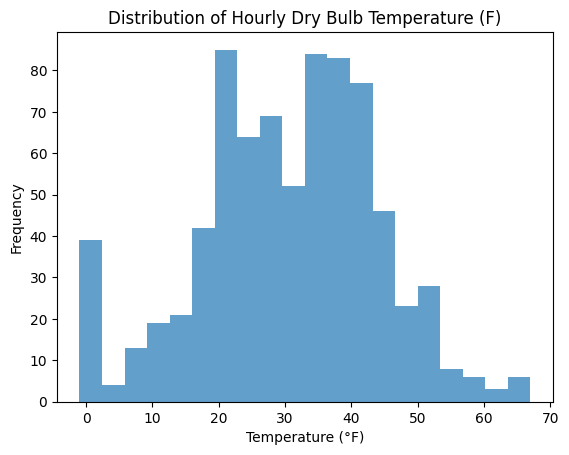

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'HourlyDryBulbTemperatureF' is within a Pandas DataFrame for visualization
df_pd = df.toPandas()  # Convert Spark DataFrame to Pandas DataFrame for plotting
plt.hist(df_pd['HourlyDryBulbTemperatureF'], bins=20, alpha=0.7)
plt.title('Distribution of Hourly Dry Bulb Temperature (F)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from pyspark.sql.functions import col

df = df.withColumn("HourlyPrecipitation", col("HourlyPrecipitation").cast("float"))
df.printSchema()  # Check to ensure the conversion was successful


root
 |-- STATION: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: string (nullable = true)
 |-- reportType: string (nullable = true)
 |-- HourlySkyConditions: string (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- HourlyPresentWeatherType: string (nullable = true)
 |-- HourlyDryBulbTemperatureF: integer (nullable = false)
 |-- HourlyDryBulbTemperatureC: double (nullable = true)
 |-- HourlyWetBulbTemperatureF: integer (nullable = true)
 |-- HourlyWetBulbTemperatureC: double (nullable = true)
 |-- HourlyDewPointTemperatureF: integer (nullable = true)
 |-- HourlyDewPointTemperatureC: double (nullable = true)
 |-- HourlyRelativeHumidity: integer (nullable = false)
 |-- HourlyWindSpeed: integer (nullable = true)
 |-- HourlyWindDirection: string (nullable = true)
 |-- HourlyWindGustSpeed: integer (nullable = true)
 |

In [ ]:
correlation_value = df.stat.corr('HourlyDryBulbTemperatureF', 'HourlyPrecipitation')
print(f"Correlation between Temperature and Precipitation: {correlation_value}")


Correlation between Temperature and Precipitation: 0.003949929727518378


In [ ]:
from pyspark.sql.functions import log, col

# Assuming 'HourlyPrecipitation' has no zero or negative values; otherwise, adjust it first
df = df.withColumn("LogHourlyPrecipitation", log(col("HourlyPrecipitation") + 1))  # Adding 1 to avoid log(0)

# Check new correlation
new_correlation = df.stat.corr('HourlyDryBulbTemperatureF', 'LogHourlyPrecipitation')
print(f"New Correlation between Temperature and Log of Precipitation: {new_correlation}")


New Correlation between Temperature and Log of Precipitation: 0.003620591388232587


In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan('HourlyPrecipitation') | col('HourlyPrecipitation').isNull(), 'HourlyPrecipitation')).alias('MissingValues')]).show()


+-------------+
|MissingValues|
+-------------+
|          721|
+-------------+



In [ ]:
df_clean = df.na.drop(subset=["HourlyPrecipitation"])
print("Remaining rows:", df_clean.count())


Remaining rows: 51


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyPrecipitation"],
    outputCols=["HourlyPrecipitationImputed"]
).setStrategy("mean")  # You can also use "median" or "mode"

df_imputed = imputer.fit(df).transform(df)
df_imputed

DataFrame[STATION: string, STATION_NAME: string, ELEVATION: double, LATITUDE: double, LONGITUDE: double, DATE: string, reportType: string, HourlySkyConditions: string, HourlyVisibility: double, HourlyPresentWeatherType: string, HourlyDryBulbTemperatureF: int, HourlyDryBulbTemperatureC: double, HourlyWetBulbTemperatureF: int, HourlyWetBulbTemperatureC: double, HourlyDewPointTemperatureF: int, HourlyDewPointTemperatureC: double, HourlyRelativeHumidity: int, HourlyWindSpeed: int, HourlyWindDirection: string, HourlyWindGustSpeed: int, HourlyStationPressure: double, HourlyPressureTendency: int, HourlyPressureChange: double, HourlySeaLevelPressure: string, HourlyPrecipitation: float, HourlyAltimeterSetting: double, DailyMaximumDryBulbTemperature: int, DailyMinimumDryBulbTemperature: int, DailyAverageDryBulbTemperature: int, DailyDepartureFromNormalAverageTemperature: double, DailyAverageRelativeHumidity: int, DailyAverageDewPointTemperature: string, DailyAverageWetBulbTemperature: int, Daily

In [ ]:
from pyspark.sql.functions import col

# Assuming you know the columns or detect them dynamically
columns_to_fill = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
fill_values = {col: 0 for col in columns_to_fill}  # Replace '0' with an appropriate value for your context
df_filled = df_imputed.na.fill(fill_values)

# Now use df_filled to fit the model
model = pipeline.fit(df_filled)


In [ ]:
for column in columns_to_fill:
    null_count = df_imputed.where(col(column).isNull()).count()
    print(f"Nulls in {column}: {null_count}")


Nulls in HourlyDryBulbTemperatureF: 0
Nulls in HourlyWindSpeed: 30
Nulls in HourlyRelativeHumidity: 0


# Decision Tree model

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features"
)


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# For a regression problem
dt = DecisionTreeRegressor(featuresCol="features", labelCol="HourlyPrecipitationImputed")

# If it was a classification problem, you'd use:
# from pyspark.ml.classification import DecisionTreeClassifier
# dt = DecisionTreeClassifier(featuresCol="features", labelCol="TargetColumn")


In [ ]:
# Columns used in the model
columns_to_fill = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
fill_values = {col: df_imputed.agg({col: "mean"}).first()[0] for col in columns_to_fill}  # Using mean to fill

# Filling null values
df_imputed_filled = df_imputed.fillna(fill_values)

# Recreate the pipeline and fit the model using the filled DataFrame
pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(df_imputed_filled)


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Configure VectorAssembler with a strategy to handle nulls
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features",
    handleInvalid="skip"  # This will skip rows with any null values
)

# Update the pipeline
pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(df_imputed_filled)


In [ ]:
# Make predictions
predictions = model.transform(df_imputed_filled)

# Show predictions
predictions.select("features", "HourlyPrecipitationImputed", "prediction").show(5)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="HourlyPrecipitationImputed",
    predictionCol="prediction",
    metricName="rmse"
)

# Calculate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


+----------------+--------------------------+--------------------+
|        features|HourlyPrecipitationImputed|          prediction|
+----------------+--------------------------+--------------------+
| [30.0,9.0,56.0]|               0.030980391|0.030980391427874565|
| [30.0,0.0,58.0]|               0.030980391|0.030980391427874565|
| [29.0,8.0,72.0]|               0.030980391| 0.02987179418022816|
| [28.0,0.0,81.0]|                      0.03|0.030951556366156128|
|[26.0,11.0,78.0]|                      0.01| 0.01777777738041348|
+----------------+--------------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.003288441194758109


In [ ]:
print(model.stages[-1].toDebugString)


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_804af8542faf, depth=5, numNodes=43, numFeatures=3
  If (feature 2 <= 81.5)
   If (feature 2 <= 71.5)
    If (feature 2 <= 67.5)
     Predict: 0.030980391427874565
    Else (feature 2 > 67.5)
     If (feature 0 <= 12.5)
      If (feature 1 <= 6.5)
       Predict: 0.030980391427874565
      Else (feature 1 > 6.5)
       Predict: 0.01699346366027991
     Else (feature 0 > 12.5)
      If (feature 0 <= 26.5)
       Predict: 0.029814814113908343
      Else (feature 0 > 26.5)
       Predict: 0.030980391427874565
   Else (feature 2 > 71.5)
    If (feature 1 <= 10.5)
     If (feature 0 <= 42.5)
      If (feature 1 <= 7.5)
       Predict: 0.030951556366156128
      Else (feature 1 > 7.5)
       Predict: 0.02987179418022816
     Else (feature 0 > 42.5)
      If (feature 2 <= 76.5)
       Predict: 0.030980391427874565
      Else (feature 2 > 76.5)
       Predict: 0.009999999776482582
    Else (feature 1 > 10.5)
     If (feature 0 <= 26.5)
    

# Plotting Daily Average Temperatures Using PySpark and matplotlib


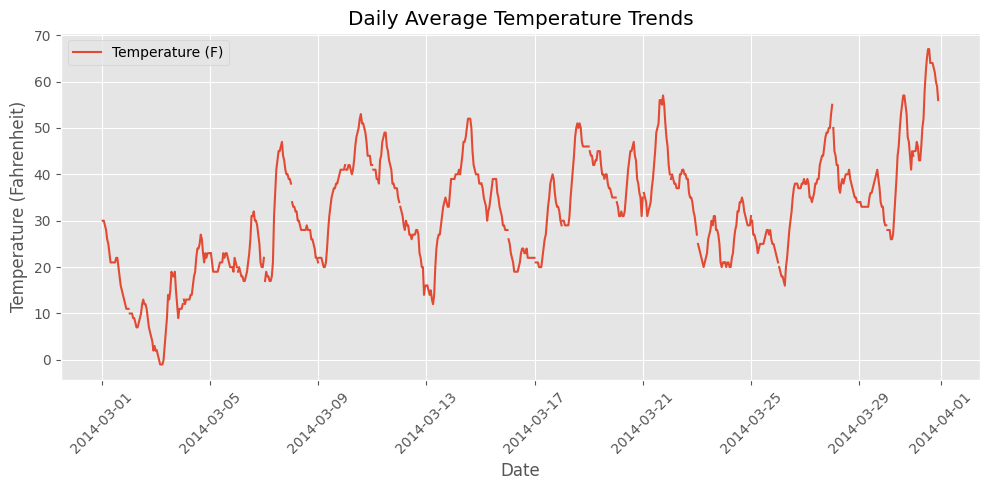

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your Spark DataFrame and you have a column 'DATE' for timestamps and 'HourlyDryBulbTemperatureF' for temperature
# First, convert Spark DataFrame to Pandas DataFrame
pandas_df = df_weather.select('DATE', 'HourlyDryBulbTemperatureF').toPandas()

# Convert DATE from string to datetime for better plotting
pandas_df['DATE'] = pd.to_datetime(pandas_df['DATE'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(pandas_df['DATE'], pandas_df['HourlyDryBulbTemperatureF'], label='Temperature (F)')
plt.title('Daily Average Temperature Trends')
plt.xlabel('Date')
plt.ylabel('Temperature (Fahrenheit)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotating date labels for better visibility
plt.tight_layout()
plt.show()


# visualization of temperature trends over time

In [ ]:
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt

# Convert the DATE column to timestamp if it's in string format
df = df_weather.withColumn("Timestamp", to_timestamp("DATE", "M/d/yyyy H:mm"))  # Adjust the date format string as necessary

# Select only the relevant columns
time_temp_df = df.select("Timestamp", "HourlyDryBulbTemperatureF").na.drop()

# Collect the data to local for plotting (Note: ensure this is feasible memory-wise, depending on your data size)
pandas_df = time_temp_df.toPandas()

# Sort by date to ensure correct plotting
pandas_df.sort_values('Timestamp', inplace=True)

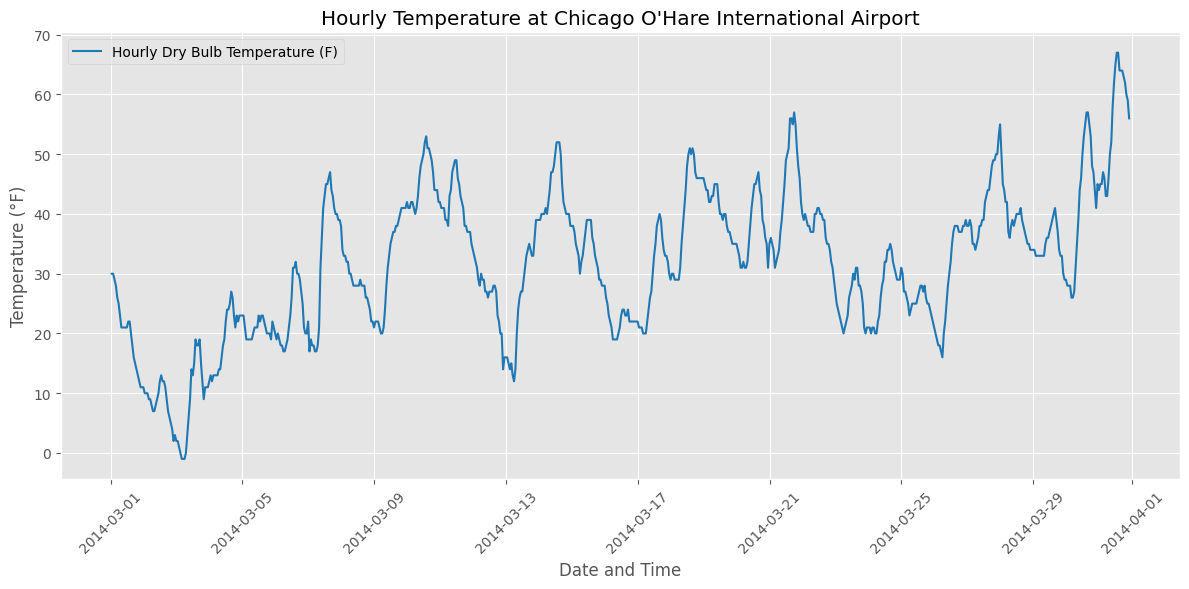

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['Timestamp'], pandas_df['HourlyDryBulbTemperatureF'], label='Hourly Dry Bulb Temperature (F)', color='tab:blue')
plt.title('Hourly Temperature at Chicago O\'Hare International Airport')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

# Visualization of precipitation patterns


In [ ]:
from pyspark.sql.functions import to_timestamp, col

# Assuming your DataFrame is named `df` and has columns 'DATE' for timestamp and 'HourlyPrecipitation' for precipitation data
# Convert the DATE column to a proper timestamp format if it hasn't been converted yet
df = df_weather.withColumn("Timestamp", to_timestamp(col("DATE"), "MM/dd/yyyy HH:mm"))

# Filter out any rows where precipitation data might be null or improperly recorded
hourly_precipitation_df = df.select("Timestamp", "HourlyPrecipitation").na.drop()



from pyspark.sql.functions import col, to_timestamp, date_trunc, when
from pyspark.sql.types import FloatType

# First, ensure your Spark session is configured to handle date parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Re-read or convert the date column to ensure it's in the correct format
df = df.withColumn("Timestamp", to_timestamp(col("DATE"), "M/d/yyyy H:mm"))

# Explicitly handle non-numeric values: convert to float, and inspect any failed conversions
hourly_precipitation_df = df.withColumn(
    "HourlyPrecipitationFloat",
    when(col("HourlyPrecipitation").rlike("^[0-9]*\.?[0-9]+([eE][+-]?[0-9]+)?$"), col("HourlyPrecipitation").cast(FloatType()))
)

# Check for non-convertible values and fill them with 0 (or choose another appropriate handling method)
hourly_precipitation_df = hourly_precipitation_df.na.fill({"HourlyPrecipitationFloat": 0})

# Now proceed with your aggregation
daily_precipitation_df = hourly_precipitation_df.groupBy(date_trunc("day", "Timestamp").alias("Date")) \
    .sum("HourlyPrecipitationFloat") \
    .withColumnRenamed("sum(HourlyPrecipitationFloat)", "DailyPrecipitation")

# Show some data to confirm it's working
daily_precipitation_df.show()

+-------------------+--------------------+
|               Date|  DailyPrecipitation|
+-------------------+--------------------+
|2014-03-14 00:00:00|                 0.0|
|2014-03-27 00:00:00|  0.1999999973922968|
|2014-03-08 00:00:00|0.009999999776482582|
|2014-03-26 00:00:00|                 0.0|
|2014-03-11 00:00:00| 0.13999999687075615|
|2014-03-16 00:00:00|                 0.0|
|2014-03-22 00:00:00|                 0.0|
|2014-03-25 00:00:00| 0.04999999888241291|
|2014-03-04 00:00:00|                 0.0|
|2014-03-15 00:00:00|                 0.0|
|2014-03-23 00:00:00|                 0.0|
|2014-03-01 00:00:00| 0.19999999552965164|
|2014-03-06 00:00:00|                 0.0|
|2014-03-07 00:00:00|                 0.0|
|2014-03-29 00:00:00|                 0.0|
|2014-03-30 00:00:00|                 0.0|
|2014-03-20 00:00:00|0.019999999552965164|
|2014-03-28 00:00:00| 0.05999999865889549|
|2014-03-05 00:00:00| 0.14999999664723873|
|2014-03-17 00:00:00|                 0.0|
+----------

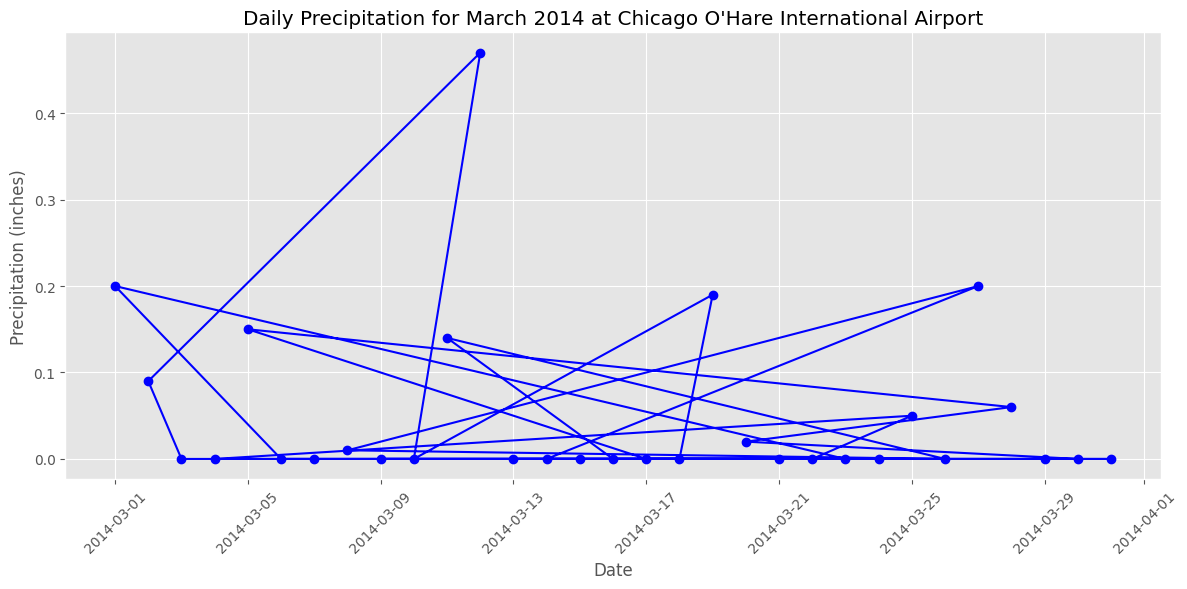

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
pandas_precipitation_df = daily_precipitation_df.toPandas()

# Convert the 'Date' column to datetime type for better plotting
pandas_precipitation_df['Date'] = pd.to_datetime(pandas_precipitation_df['Date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pandas_precipitation_df['Date'], pandas_precipitation_df['DailyPrecipitation'], marker='o', linestyle='-', color='b')
plt.title('Daily Precipitation for March 2014 at Chicago O\'Hare International Airport')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Analyzing wind speed and direction

In [ ]:
!pip install windrose

+---------------+-------------------+
|HourlyWindSpeed|HourlyWindDirection|
+---------------+-------------------+
|              0|                  0|
+---------------+-------------------+



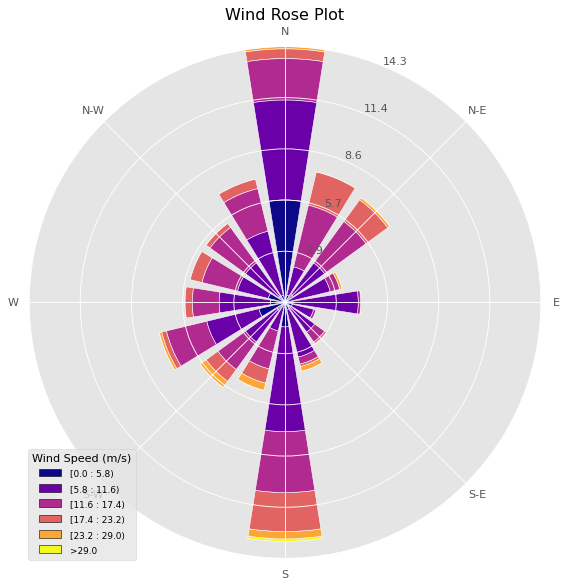

In [ ]:
from pyspark.sql.functions import col, isnan, when, count
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# Assuming 'df' is your PySpark DataFrame
# Cast the wind speed and direction columns to float
df_wind = df_weather.withColumn("HourlyWindSpeed", col("HourlyWindSpeed").cast("float"))
df_dir = df_weather.withColumn("HourlyWindDirection", col("HourlyWindDirection").cast("float"))

# Filter out any rows that have nulls in these columns after conversion
df = df.filter(df["HourlyWindSpeed"].isNotNull() & df["HourlyWindDirection"].isNotNull())

# Check for any rows where casting resulted in nulls
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["HourlyWindSpeed", "HourlyWindDirection"]]).show()

# If you need to fill nulls (after confirming their source)
df = df.na.fill({"HourlyWindSpeed": 0, "HourlyWindDirection": 0})
# Convert the HourlyWindDirection column to float
df = df.withColumn("HourlyWindDirection", col("HourlyWindDirection").cast("float"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pdf = df.select("HourlyWindSpeed", "HourlyWindDirection").toPandas()

# Create wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(pdf['HourlyWindDirection'], pdf['HourlyWindSpeed'], normed=True, opening=0.8, edgecolor='white', cmap=cm.plasma)
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Rose Plot')
plt.show()

